Feature Engineering
Better preprocessing
Tuning
hyperparameter optimization

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 33.33%
Feature importances: [('Gender_Mænd', 0.07636067258781264), ('Gender_Kvinder', 0.067965679396979), ('Gender_Uoplyst køn', 0.060900375967527925), ('Area_Region Syddanmark', 0.05436328333053777), ('Age_65 år og derover', 0.049092720647443674), ('Age_0-17 år', 0.049083581670563495), ('Area_Region Sjælland', 0.04826510793186228), ('Area_Region Hovedstaden', 0.047764939170360905), ('Area_Region Midtjylland', 0.04595171098903214), ('Age_Uoplyst alder', 0.0436057985902964), ('Area_Region Nordjylland', 0.04359617196451087), ('Age_45-64 år', 0.043364967866387535), ('Age_25-44 år', 0.04247026515412886), ('Age_18-24 år', 0.03910455961994984), ('Type of Vehicle_Varebil 0-3.500 kg.', 0.037406566918964566), ('Type of Vehicle_Knallert', 0.034892280747150166), ('Type of Vehicle_Lastbil over 3.500 kg.', 0.0

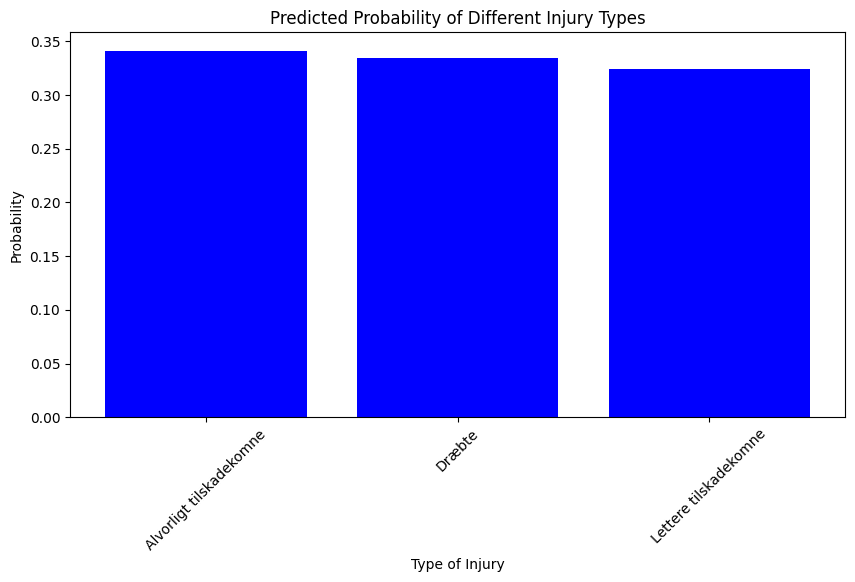

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import graphviz

# Load data
column_names = ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle', '2020', '2021', '2022']
data = pd.read_csv('../20244281821457313338UHELDK129906013912.csv', names=column_names, sep=';', encoding='ISO-8859-1')

# Data preprocessing
data['Total Incidents'] = data[['2020', '2021', '2022']].sum(axis=1)
data.drop(['2020', '2021', '2022'], axis=1, inplace=True)
data = data[data['Type of Injury'] != 'Personskade i alt']

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=True)  # Adjusted according to sklearn's future changes
encoded_features = encoder.fit_transform(data[['Gender', 'Age', 'Area', 'Type of Vehicle']])
feature_names = encoder.get_feature_names_out(['Gender', 'Age', 'Area', 'Type of Vehicle'])
X = pd.DataFrame(encoded_features.toarray(), columns=feature_names)
y = data['Type of Injury']

# Convert class names to string explicitly
class_names = [str(cls) for cls in y.unique()]

# Setting up the RandomForest Classifier
model = RandomForestClassifier(random_state=2, class_weight='balanced')

# Grid search for hyperparameter tuning
param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_ * 100))

# Fit model on the entire dataset with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X, y)

# Evaluate feature importances
importances = best_model.feature_importances_
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
print("Feature importances:", sorted_features)

# Extract one tree from the forest
single_tree = best_model.estimators_[0]

# Generate DOT data for the single tree
dot_data = export_graphviz(single_tree, out_file=None, 
                           feature_names=feature_names,  
                           class_names=class_names,
                           filled=True)

# Draw graph and save to file
graph = graphviz.Source(dot_data, format="png")
graphs_dir = "graphs"
os.makedirs(graphs_dir, exist_ok=True)
graph_path = os.path.join(graphs_dir, "decision_tree.png")
graph.render(graph_path)

# Prediction function
def predict_injury_type(user_data):
    input_df = pd.DataFrame([user_data], columns=['Gender', 'Age', 'Area', 'Type of Vehicle'])
    encoded_input = encoder.transform(input_df)
    input_features = pd.DataFrame(encoded_input.toarray(), columns=feature_names)
    probabilities = best_model.predict_proba(input_features)[0]
    injury_types = best_model.classes_
    return {str(injury_types[i]): prob for i, prob in enumerate(probabilities)}

# Example user input and prediction
user_input = {
    'Gender': 'Mænd',
    'Age': '45-64 år',
    'Area': 'Region Hovedstaden',
    'Type of Vehicle': 'Cykel'
}
predicted_probabilities = predict_injury_type(user_input)
print("Predicted probabilities for the user input:")
print(predicted_probabilities)

# Visualization of probabilities
plt.figure(figsize=(10, 5))
plt.bar(predicted_probabilities.keys(), predicted_probabilities.values(), color='blue')
plt.xlabel('Type of Injury')
plt.ylabel('Probability')
plt.title('Predicted Probability of Different Injury Types')
plt.xticks(rotation=45)
plt.show()


In [24]:
# Example user input and prediction
user_input = {
    'Gender': 'Mænd',
    'Age': '45-64 år',
    'Area': 'Region Hovedstaden',
    'Type of Vehicle': 'Cykel'
}
predicted_probabilities = predict_injury_type(user_input)
print(predicted_probabilities)

{'Alvorligt tilskadekomne': 0.34138590640576516, 'Dræbte': 0.3341223379974607, 'Lettere tilskadekomne': 0.3244917555967741}


In [22]:
"""
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y are already defined and represent the entire dataset's features and labels

# Predict on the entire dataset
predictions = model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, predictions)
print("Accuracy on the entire dataset: {:.2f}%".format(accuracy * 100))

# Print classification report for more details
report = classification_report(y, predictions)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y, predictions)
print("Confusion Matrix:\n", conf_matrix)
"""

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.